# PCA

This comes from the example notebook and the [tour of scikit-allel](http://alimanfoo.github.io/2016/06/10/scikit-allel-tour.html) blog post.

Up until this point we have:

1. Looked at distributions to give us an overview of the Variant Attributes in `001-Exploratory-Statistics-Variant-Attributes`
2. Looked at distributions to give us an overview of Variant Quality in `002-Exploratory-Statistics-Variant-Quality`

Once we've done the initial exploratory analysis we want to start to remove variants that are of poor quality (or some other metric) and variants that don't give us any information on segrating our populations. 

3. Filtered variants based on Variant Attributes and Variant Quality in `003-Filter-Variants`
4. Filtered variants based on their Sample Missingingness, Sample Heterozygosity, and Variants that don't segregate our populations in `004-Exploratory-Statistics-Sample-QC`.

All along the way we have continually filtered our genotypes based on findings from the exploratory statistics and QC.



In [2]:
import numpy as np
import zarr
import pandas as pd
import dask.array as da
import allel
import scipy
from pprint import pprint

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
%matplotlib inline

In [3]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=30)
cluster

distributed.scheduler - INFO - Clear task state
/opt/conda/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
distributed.scheduler - INFO -   Scheduler at:   tcp://10.35.63.92:33931
distributed.scheduler - INFO -   dashboard at:                    :44035


## Import the Variant Data

In [4]:
import gcsfs

gcs_bucket_fs = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='anon', access='read_only')

storage_path = 'ag1000g-release/phase2.AR1/variation/main/zarr/pass/ag1000g.phase2.ar1.pass'
store = gcsfs.mapping.GCSMap(storage_path, gcs=gcs_bucket_fs, check=False, create=False)
callset = zarr.Group(store)

In [5]:
chrom = '3L'

# All the variants
variants = allel.VariantChunkedTable(callset[chrom]['variants'], 
                                     names=['POS', 'REF', 'ALT', 'DP', 'MQ', 'QD'],
                                     index='POS')
variants

<VariantChunkedTable shape=(10640388,) dtype=[('POS', '<i4'), ('REF', 'S1'), ('ALT', 'S1', (3,)), ('DP', '<i4'), ('MQ', '<f4'), ('QD', '<f4')]
   nbytes=202.9M cbytes=-6 cratio=-35467960.0
   values=zarr.hierarchy.Group>

## Filter Variants

In [6]:
# Take a look at 003-Filter-Variants.ipyng for a more indepth look on filtering variants

def filter_variants(table, expression='(QD > 5) & (MQ > 40) & (DP > 15000) & (DP < 30000)'):
    """Filter a VariantChunkedTable based on a python expression"""
    selection = table.eval(expression)[:]
    return selection, table.compress(selection)

In [7]:
variant_selection, variants_pass = filter_variants(variants)
variants_pass

<VariantChunkedTable shape=(304050,) dtype=[('POS', '<i4'), ('REF', 'S1'), ('ALT', 'S1', (3,)), ('DP', '<i4'), ('MQ', '<f4'), ('QD', '<f4')]
   nbytes=5.8M cbytes=3.3M cratio=1.7
   values=allel.chunked.storage_zarr.ZarrTable>

In [8]:
variant_selection

array([False, False, False, ..., False, False, False])

## Subset genotypes

Let's subset the genotypes so we can more effectively look at our samples QC.

See 004-Subset-Genotypes for a more indepth explanation.

In [9]:
calldata = callset[chrom]['calldata']
# In phase 1 data this is 
# genotypes = allel.GenotypeChunkedArray(calldata['genotype'])
genotypes = allel.GenotypeChunkedArray(calldata['GT'])
genotypes

<GenotypeChunkedArray shape=(10640388, 1142, 2) dtype=int8 chunks=(524288, 61, 2)
   nbytes=22.6G cbytes=-1 cratio=-24302646192.0
   compression=blosc compression_opts={'cname': 'zstd', 'clevel': 1, 'shuffle': -1, 'blocksize': 0}
   values=zarr.core.Array>

In [10]:
!wget --no-clobber ftp://ngs.sanger.ac.uk/production/ag1000g/phase2/AR1/samples/samples.meta.txt

File ‘samples.meta.txt’ already there; not retrieving.


In [11]:
samples = pd.read_csv('samples.meta.txt', sep='\t')
sample_selection = samples.population.isin({'GHcol', 'GHgam'}).values
samples_subset = samples[sample_selection]
samples_subset.reset_index(drop=True, inplace=True)

Let’s work with two populations only for simplicity.

Now let’s subset the genotype calls to keep only variants that pass our quality filters and only samples in our two populations of interest.

In [12]:
%%time
genotypes_subset = genotypes.subset(variant_selection, sample_selection)

CPU times: user 1min 32s, sys: 11.5 s, total: 1min 44s
Wall time: 57 s


In [13]:
genotypes_subset

<GenotypeChunkedArray shape=(304050, 67, 2) dtype=int8 chunks=(4751, 67, 2)
   nbytes=38.9M cbytes=2.7M cratio=14.4
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

## Sample QC

Before we go any further, let’s do some sample QC. This is just to check if any of the samples we’re working with have major quality issues that might confound an analysis.

Compute the percent of missing and heterozygous genotype calls for each sample.

In [14]:
%%time
n_variants = len(variants_pass)
pc_missing = genotypes_subset.count_missing(axis=0)[:] * 100 / n_variants
pc_het = genotypes_subset.count_het(axis=0)[:] * 100 / n_variants

CPU times: user 984 ms, sys: 24.8 ms, total: 1.01 s
Wall time: 956 ms


## Sample QC - Missingness

We didn't have any samples with a high degree of missingness, but for the full analysis please see `005-Exploratory-Statistics-Sample-QC`.

## Sample QC - Allele Count

As a first step into doing some population genetic analyses, let’s perform an allele count within each of the two populations we’ve selected. This just means, for each SNP, counting how many copies of the reference allele (0) and each of the alternate alleles (1, 2, 3) are observed.

To set this up, define a dictionary mapping population names onto the indices of samples within them.

In [15]:
#'GHcol', 'GHgam'
subpops = {
    'all': list(range(len(samples_subset))),
    'GHcol': samples_subset[samples_subset.population == 'GHcol'].index.tolist(),
    'GHgam': samples_subset[samples_subset.population == 'GHgam'].index.tolist(),
}


UsageError: Line magic function `%%time` not found.


Now perform the allele count.

In [16]:
%%time
ac_subpops = genotypes_subset.count_alleles_subpops(subpops, max_allele=3)

CPU times: user 578 ms, sys: 54.8 ms, total: 633 ms
Wall time: 512 ms


In [17]:
ac_subpops

<AlleleCountsChunkedTable shape=(304050,) dtype=[('GHcol', '<i4', (4,)), ('GHgam', '<i4', (4,)), ('all', '<i4', (4,))]
   nbytes=13.9M cbytes=1.2M cratio=11.2
   values=allel.chunked.storage_zarr.ZarrTable>

## Sample QC - Locate segregating variants

There are lots of SNPs which do not segregate in either of these populations are so are not interesting for any analysis of these populations. We might as well get rid of them.

In [21]:
is_seg = ac_subpops['all'].is_segregating()[:]

## Subset the genotypes based on segregating variants

In [22]:
genotypes_seg = genotypes_subset.compress(is_seg, axis=0)
genotypes_seg

<GenotypeChunkedArray shape=(105749, 67, 2) dtype=int8 chunks=(3305, 67, 2)
   nbytes=13.5M cbytes=2.6M cratio=5.3
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [23]:
variants_seg = variants_pass.compress(is_seg)
variants_seg

<VariantChunkedTable shape=(105749,) dtype=[('POS', '<i4'), ('REF', 'S1'), ('ALT', 'S1', (3,)), ('DP', '<i4'), ('MQ', '<f4'), ('QD', '<f4')]
   nbytes=2.0M cbytes=1.2M cratio=1.7
   values=allel.chunked.storage_zarr.ZarrTable>

In [24]:
ac_seg = ac_subpops.compress(is_seg)
ac_seg

<AlleleCountsChunkedTable shape=(105749,) dtype=[('GHcol', '<i4', (4,)), ('GHgam', '<i4', (4,)), ('all', '<i4', (4,))]
   nbytes=4.8M cbytes=745.3K cratio=6.7
   values=allel.chunked.storage_zarr.ZarrTable>

# Principal components analysis - PCA

Finally, let’s to a quick-and-dirty PCA to confirm our evidence for differentiation between these two populations and check if there is any other genetic structure within populations that we might have missed.

First grab the allele counts for the union of the two populations.

In [25]:
ac = ac_seg['all'][:]
ac

<AlleleCountsArray shape=(105749, 4) dtype=int32>
125   9   0   0
133   1   0   0
133   1   0   0
...
132   2   0   0
133   1   0   0
133   1   0   0

distributed.scheduler - INFO - Register tcp://10.35.176.2:41981
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.176.2:41981
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.35.184.2:35709
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.184.2:35709
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.35.198.2:34963
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.198.2:34963
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.35.185.2:44869
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.185.2:44869
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.35.200.2:33743
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.200.2:33743
distributed.c

Select the variants to use for the PCA, including only biallelic SNPs with a minor allele count above 2.

In [26]:
pca_selection = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 2)
pca_selection

array([ True, False, False, ..., False, False, False])

distributed.scheduler - INFO - Register tcp://10.35.195.2:43479
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.195.2:43479
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.35.170.2:42675
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.170.2:42675
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.35.196.2:44227
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.196.2:44227
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.35.189.2:34561
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.189.2:34561
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.35.172.2:41939
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.172.2:41939
distributed.c

In [27]:
np.count_nonzero(pca_selection)

37206

Now randomly downsample these SNPs purely for speed.

In [28]:
indices = np.nonzero(pca_selection)[0]
indices

array([     0,     11,     12, ..., 105740, 105743, 105745])

In [29]:
len(indices)

37206

In [31]:
indices_ds = np.random.choice(indices, size=30000, replace=False)
indices_ds.sort()
indices_ds

array([     0,     12,     22, ..., 105728, 105738, 105743])

Subset the genotypes to keep only our selected SNPs for PCA.

In [32]:
genotypes_pca = genotypes_seg.take(indices_ds, axis=0)
genotypes_pca

<GenotypeChunkedArray shape=(30000, 67, 2) dtype=int8 chunks=(3750, 67, 2)
   nbytes=3.8M cbytes=1.1M cratio=3.4
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [33]:
gn = genotypes_pca.to_n_alt()[:]
gn

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 2, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

# PCA

We're going to run the PCA several times - once with SciKit Allele, one with SkLearn, and once with Dask ML

The PCA itself is the same, but SciKit Allele does a SVD on the explained variance and scales based on the number of samples

In [44]:
#'GHcol', 'GHgam'

def plot_pca_coords(coords, model, pc1, pc2, ax):
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in ['GHcol', 'GHgam']:
        flt = (samples_subset.population == pop).values
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', label=pop, markersize=6)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))

## PCA - SciKit Allele

Let's run the SK Allele PCA to get the first 10 principal components

In [40]:
coords, model = allel.stats.decomposition.pca(gn)

In [41]:
coords.shape

(67, 10)

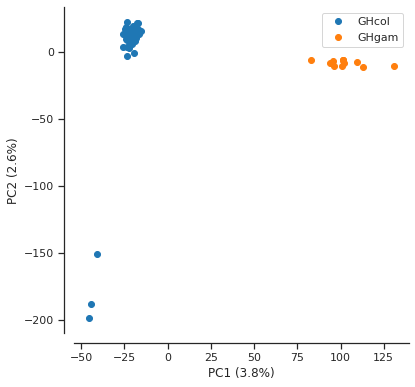

In [45]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax)
ax.legend();

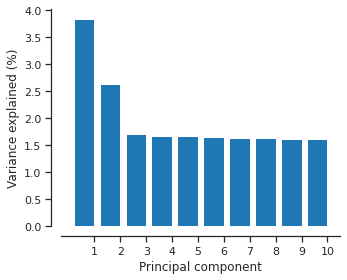

In [43]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.despine(ax=ax, offset=10)
y = 100 * model.explained_variance_ratio_
x = np.arange(len(y))
ax.set_xticks(x + .4)
ax.set_xticklabels(x + 1)
ax.bar(x, y)
ax.set_xlabel('Principal component')
ax.set_ylabel('Variance explained (%)');

## PCA - SKLearn

In [56]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [57]:
%%timeit
X=gn
pca = PCA(n_components=10)
X_r = pca.fit(gn).transform(gn)

243 ms ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


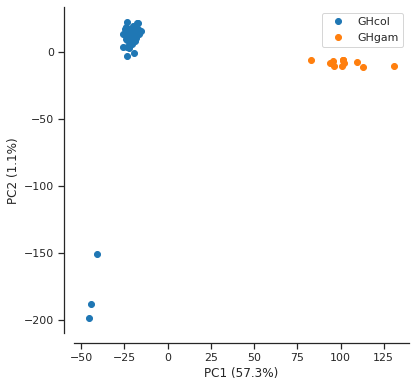

In [58]:
def plot_sk_pca_coords(coords, model, pc1, pc2, ax):
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in ['GHcol', 'GHgam']:
        flt = (samples_subset.population == pop).values
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', label=pop, markersize=6)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, pca.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, pca.explained_variance_ratio_[1]*100))
    
fig, ax = plt.subplots(figsize=(6, 6))
sns.despine(ax=ax, offset=10)
plot_sk_pca_coords(coords, X_r, 0, 1, ax)
ax.legend();

## PCA - Dask ML

In [59]:
import numpy as np
import dask.array as da
from dask_ml.decomposition import PCA
import dask.array as da

In [60]:
%%timeit
X = da.from_array(gn, chunks=(1000, 1000))
pca = PCA(n_components=10)
X_r = pca.fit(X).transform(X)

935 ms ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


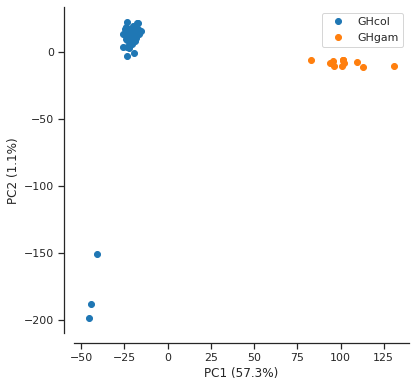

In [61]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.despine(ax=ax, offset=10)
plot_sk_pca_coords(coords, X_r, 0, 1, ax)
ax.legend();

## Get SciKit Learn Scaled Explained Variance

SciKit Allele generates its own explained variance scores

In [73]:
# TODO - This is not correct - we should get the same numbers from explained_variance_ratio as from model.explained_variance_ratio

# Code comes from here - https://scikit-allel.readthedocs.io/en/stable/_modules/allel/stats/decomposition.html#pca

import scipy.linalg
# transpose for svd
# TODO eliminate need for transposition
x = gn.T
n_samples, n_features = x.shape

# singular value decomposition
u, s, v = scipy.linalg.svd(x, full_matrices=False)

# calculate explained variance
explained_variance_ = (s ** 2) / n_samples
explained_variance_ratio_ = (explained_variance_ / np.sum(explained_variance_))

# store variables
n_components = pca.n_components
components_ = v[:n_components]
explained_variance_ = explained_variance_[:n_components]
explained_variance_ratio_ = explained_variance_ratio_[:n_components]

In [71]:
explained_variance_ratio_

array([0.69164264, 0.01310194, 0.00806277, 0.0052955 , 0.00524026,
       0.00520587, 0.00516884, 0.00510717, 0.00508698, 0.00508103],
      dtype=float32)

In [72]:
model.explained_variance_ratio_

array([0.03837809, 0.02642039, 0.01712264, 0.01677987, 0.01667323,
       0.01652299, 0.01639329, 0.01630345, 0.01626193, 0.01615529],
      dtype=float32)